# Volume residual

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import *
from src.ab_initio import ab_initio, ab_initio_mcmc
from src.residual import get_volume_residual
import jax

import mrcfile

plt.rcParams["figure.figsize"]=6,6

In [3]:
data_dir = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/"
#star_file = "Projections/crossvalidation1_sub/crossvalidation1_sub.star"
#star_file = "Projections/crossvalidation1/crossvalidation1.star"
star_file = "Projections/crossvalidation1_zeros/crossvalidation1_zeros.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)
ctf_params0 = params0["ctf_params"]
pixel_size0 = params0["pixel_size"]
angles0 = params0["angles"]
shifts0 = params0["shifts"]

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles:  26380
load_data: data loaded, time:  37.32973766326904


In [4]:
print(jnp.max(imgs0))
print(jnp.mean(imgs0))

6.80121
0.0031396088


In [5]:
print(imgs0.shape)
print(pixel_size0.shape)
print(angles0.shape)
print(shifts0.shape)
print(ctf_params0.shape)
nx0 = imgs0.shape[-1]
#plt.imshow(np.abs(jnp.fft.fftshift(imgs_f0[101]))); plt.colorbar()



(26380, 320, 320)
(26380,)
(26380, 3)
(26380, 2)
(26380, 9)


In [6]:
N = imgs0.shape[0]

if N < imgs0.shape[0]:
    idxrand = np.random.permutation(imgs0.shape)[:N]
else:
    idxrand = jnp.arange(N)
    
imgs0 = imgs0[idxrand]
pixel_size = pixel_size0[idxrand]
angles = angles0[idxrand]
shifts = shifts0[idxrand]
ctf_params = ctf_params0[idxrand]

#file2 = open(out_dir + '/idxrand','wb')
#pickle.dump(idxrand, file2)
#file2.close()

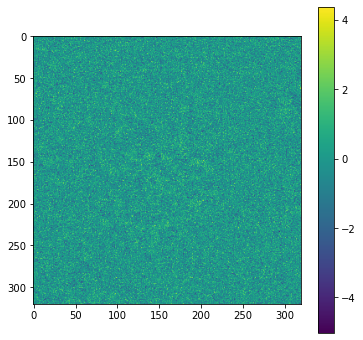

In [7]:
idx =123
plt.imshow(imgs0[idx]);plt.colorbar()

In [8]:
t0 = time.time()
imgs_f = np.array([np.fft.fft2(np.fft.ifftshift(img)) for img in imgs0])
print(time.time()-t0)

74.03527760505676


In [9]:
# Assume the pixel size is the same for all images
nx = imgs_f.shape[-1]
px = pixel_size[0]
N = imgs_f.shape[0]

x_grid = create_grid(nx, px)
y_grid = x_grid
z_grid = x_grid
print(x_grid)

[2.38549618e-03 3.20000000e+02]


### Crop images

In [10]:
nx = 128 #64
x_grid_nx0 = x_grid
imgs_f, x_grid = crop_fourier_images(imgs_f, x_grid_nx0, nx)

y_grid = x_grid
z_grid = x_grid
print(x_grid)



[2.38549618e-03 1.28000000e+02]


In [11]:
imgs_f = imgs_f.reshape(N,-1)
print(imgs_f.shape)

(26380, 16384)


### More processing

Text(0.5, 1.0, 'Estimated noise')

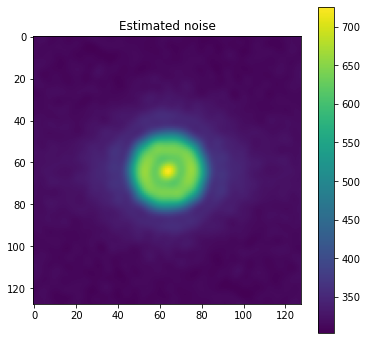

In [12]:
N_noise = 48
sigma_noise_estimated = estimate_noise_imgs(imgs0[:5000], nx_empty = N_noise, nx_final = nx).reshape([nx,nx])
plt.imshow(jnp.fft.fftshift(sigma_noise_estimated)); plt.colorbar()
plt.title('Estimated noise')

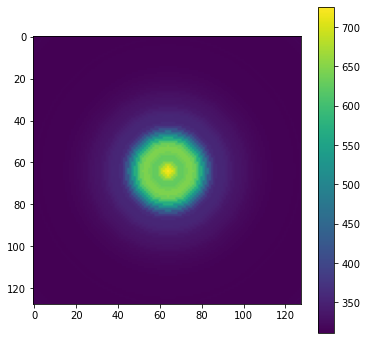

In [13]:
sigma_noise_avg = average_radially(sigma_noise_estimated, x_grid)
plt.imshow(jnp.fft.fftshift(sigma_noise_avg)); plt.colorbar()

In [14]:
sigma_noise = sigma_noise_avg.reshape(-1)

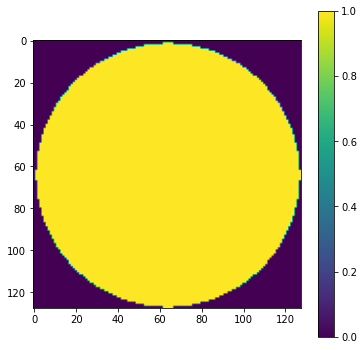

In [15]:
radius = 0.074 * 2.032
mask = create_3d_mask(x_grid, (0,0,0),radius)
mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

### Get residual

In [16]:
x_grid

array([2.38549618e-03, 1.28000000e+02])

In [17]:
jnp.complex128

jax._src.numpy.lax_numpy.complex128

In [18]:
mask2d = mask[0]

In [19]:
aa = jnp.array([[0,0],[0.1,0.1],[2,3], [0.14, 0.0001], [4, 20]])

In [20]:
aa.shape

(5, 2)

In [21]:
myidx = jnp.apply_along_axis(lambda x : x[0]**2 + x[1]**2 <= radius**2, axis=1, arr=aa)

In [22]:
myidx

DeviceArray([ True,  True, False,  True, False], dtype=bool)

In [23]:
aa[myidx]

DeviceArray([[0.0e+00, 0.0e+00],
             [1.0e-01, 1.0e-01],
             [1.4e-01, 1.0e-04]], dtype=float64)

In [24]:
x_grid

array([2.38549618e-03, 1.28000000e+02])

In [25]:
imgs_f.shape

(26380, 16384)

In [26]:
sigma_noise.shape

(16384,)

In [27]:
imgs_f[:10].shape

(10, 16384)

In [28]:
sigma_noise.shape

(16384,)

In [148]:
x = jnp.arange(12).reshape([3,4])
a, b, c = x

x

DeviceArray([[ 0,  1,  2,  3],
             [ 4,  5,  6,  7],
             [ 8,  9, 10, 11]], dtype=int64)

In [151]:
x.transpose()

DeviceArray([[ 0,  4,  8],
             [ 1,  5,  9],
             [ 2,  6, 10],
             [ 3,  7, 11]], dtype=int64)

In [215]:
N_batches = 600 # for full dataset and 64

vol, vol_sigma, vol_counts = get_volume_residual(imgs_f, angles, sigma_noise, x_grid, radius, N_batches)

Rotate each image and get list of coords. 26380 images in 10 batches...done in 19.94827389717102 seconds.
Average residuals in each voxel. 329354300 residuals in 600 batches.
Batch 0, 0.5698225498199463 seconds.
Batch 10, 0.04031968116760254 seconds.
Batch 20, 0.04097604751586914 seconds.
Batch 30, 0.04118227958679199 seconds.
Batch 40, 0.040616750717163086 seconds.
Batch 50, 0.04040026664733887 seconds.
Batch 60, 0.040360450744628906 seconds.
Batch 70, 0.04069161415100098 seconds.
Batch 80, 0.041023969650268555 seconds.
Batch 90, 0.04087471961975098 seconds.
Batch 100, 0.04016518592834473 seconds.
Batch 110, 0.040015220642089844 seconds.
Batch 120, 0.04041862487792969 seconds.
Batch 130, 0.04388761520385742 seconds.
Batch 140, 0.04012918472290039 seconds.
Batch 150, 0.040953874588012695 seconds.
Batch 160, 0.04081130027770996 seconds.
Batch 170, 0.04079747200012207 seconds.
Batch 180, 0.0442502498626709 seconds.
Batch 190, 0.04065132141113281 seconds.
Batch 200, 0.04087328910827637 se

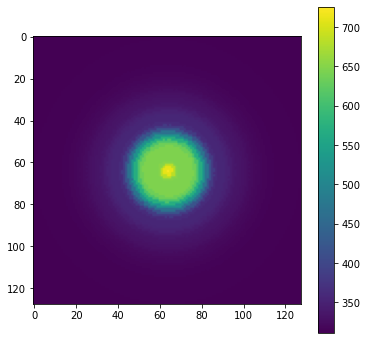

In [216]:
plt.imshow(jnp.max(jnp.fft.fftshift(vol_sigma), axis=0), vmin=jnp.min(sigma_noise_avg), vmax=jnp.max(sigma_noise_avg)); plt.colorbar()

In [217]:
print(jnp.max(vol_sigma))
print(jnp.max(sigma_noise_avg))

726.10693359375
726.10693359375


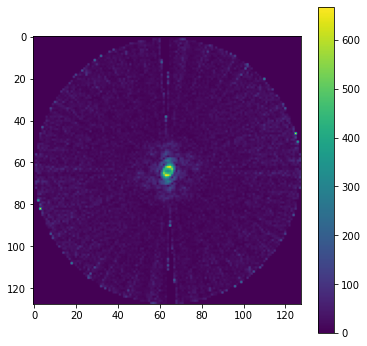

In [218]:
plt.imshow(jnp.abs(jnp.fft.fftshift(vol[0]))); plt.colorbar()

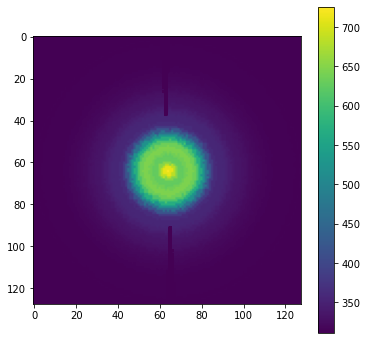

In [219]:
plt.imshow(jnp.fft.fftshift(vol_sigma[0]), vmin=jnp.min(sigma_noise_avg)); plt.colorbar()

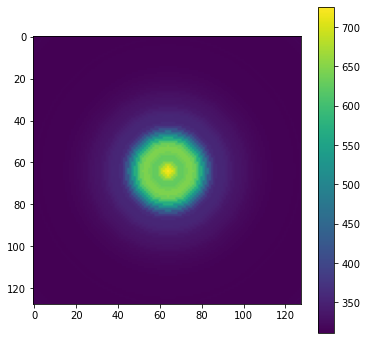

In [220]:
plt.imshow(jnp.fft.fftshift(sigma_noise_avg)); plt.colorbar()

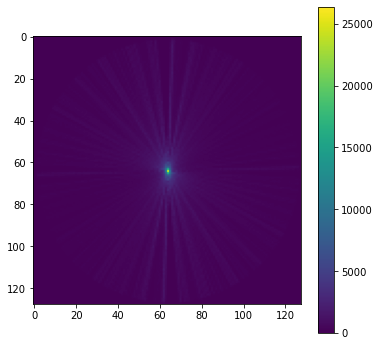

In [221]:
plt.imshow(jnp.fft.fftshift(vol_counts[0])); plt.colorbar()

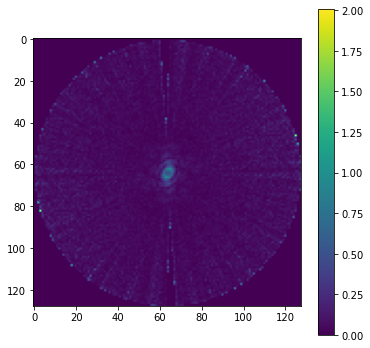

In [222]:
vs = vol/(vol_sigma+1e-16)

plt.imshow(jnp.abs(jnp.fft.fftshift(vs[0]))); plt.colorbar()

In [179]:
N = 10
A = jnp.zeros([N, N, N])
#A = A.at[0,0,0].set(2000)
#A = A.at[0,0,1].set(3000)

In [180]:
x = jnp.array([0,0,0])
y = jnp.array([0,0,0])
z = jnp.array([0,1,1])

xyz = jnp.ravel_multi_index((x,y,z), dims = A.shape)

In [181]:
B = A.reshape(-1).at[xyz].set([8880,9990, 3]).reshape([N,N,N])

In [182]:
B

DeviceArray([[[8.88e+03, 3.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
               0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
              [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
               0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
              [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
               0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
              [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
               0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
              [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
               0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
              [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
               0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
              [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
               0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
              [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
               0.0

In [99]:
B = A
B = B.at[0,0,0].set(1000)
B = B.at[0,0,1].set(2000)


DeviceArray([[[1000., 2000.,    0.,    0.,    0.,    0.,    0.,    0.,
                  0.,    0.],
              [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
                  0.,    0.],
              [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
                  0.,    0.],
              [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
                  0.,    0.],
              [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
                  0.,    0.],
              [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
                  0.,    0.],
              [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
                  0.,    0.],
              [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
                  0.,    0.],
              [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
                  0.,    0.],
              [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
                  0.

In [73]:
@jax.jit
def myfunc(B):
    return jnp.matmul(A, B)

In [83]:
myfunc2 = jax.jit(lambda C : jnp.matmul(A, C))

In [81]:
t0 = time.time()
bb = myfunc(B)
bb.block_until_ready()
print(time.time()-t0)

0.30991482734680176


In [89]:
t0 = time.time()
bb = myfunc2(B)
bb.block_until_ready()
print(time.time()-t0)

0.3027036190032959


In [46]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_resid3[0]))); plt.colorbar()

NameError: name 'v_resid3' is not defined

In [208]:
plt.imshow(jnp.fft.fftshift(v_resid[:,:,0]*mask[:,:,0])); plt.colorbar()

NameError: name 'v_resid' is not defined

In [ ]:
v_resid_print = jnp.fft.fftshift(v_resid*mask)
with mrcfile.new('../data/cryodrgn_crossvalidation/v_resid_cv2_128.mrc', overwrite=True) as mrc:
    mrc.set_data(v_resid_print.astype(np.float32))

In [45]:
r0 = mrcfile.open('../data/cryodrgn_crossvalidation/v_resid_cv1_zero_64.mrc').data
rv = mrcfile.open('../data/cryodrgn_crossvalidation/v_resid_cv1_64_proj.mrc').data

In [36]:
jnp.sum(jnp.abs(r0-rv))

DeviceArray(5041074., dtype=float32)

In [25]:
r0 = mrcfile.open('../data/cryodrgn_crossvalidation/v_resid_cv1_zero_128.mrc').data
rv = mrcfile.open('../data/cryodrgn_crossvalidation/v_resid_cv1_128.mrc').data


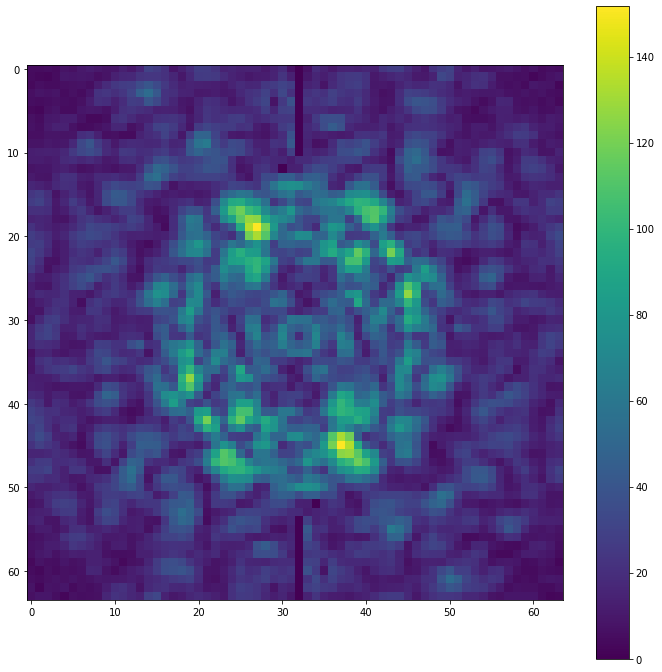

In [49]:
plt.imshow(rv[:,:,32]); plt.colorbar()

In [32]:
jnp.sum(jnp.abs(r0-rv))

DeviceArray(0., dtype=float32)

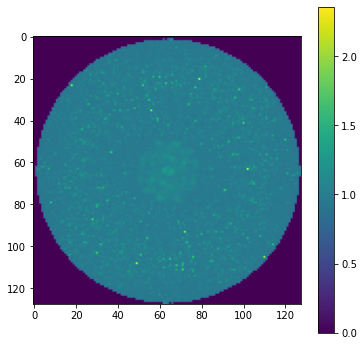

In [30]:
mip_z(rv); plt.colorbar()

### New volumes

In [24]:
with open('../data/cryodrgn_crossvalidation/cv1_proj_32', 'rb') as file:
    # Call load method to deserialze
    proj = pickle.load(file)


In [29]:
proj[0,0]

array([ 19.01725458,  35.90536084,  45.91661398,  16.16830083,
        -3.36572933, -13.29117774,  -6.34324598,   1.37270153,
         7.37385469,   6.56053346,   4.03242771,   2.40700772,
         3.34642496,   2.60984252,   1.15996835,   1.03297985,
        -0.04606021,   0.55394648,   0.81718212,   2.72114988,
         3.42498891,   2.42703735,   4.12682434,   6.56053346,
         7.37385469,   1.37270153,  -6.34324598, -13.29117774,
        -3.36572933,  16.16830083,  45.91661398,  35.90536084])